In [1]:
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud
from pandarallel import pandarallel
from matplotlib import pyplot as plt

from reviews.config import processed_data_dir
from reviews.utils import flat_sentence_tokens, preprocess_df

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Prepare Data

In [2]:
# read data
reviews_df = pd.read_json(
    processed_data_dir / "products_reviews.json.gz", orient="records"
)

reviews_df["summary"] = reviews_df["summary"].astype("string")
reviews_df["text"] = reviews_df["text"].astype("string")

reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183777 entries, 0 to 183776
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   asin             183777 non-null  object        
 1   overall          183777 non-null  int64         
 2   summary          183777 non-null  string        
 3   text             183777 non-null  string        
 4   timestamp        183777 non-null  datetime64[ns]
 5   vote             183777 non-null  int64         
 6   brand            183777 non-null  object        
 7   category         183777 non-null  object        
 8   description      178347 non-null  object        
 9   imageURLHighRes  151801 non-null  object        
 10  title            183777 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6), string(2)
memory usage: 16.8+ MB


In [3]:
from reviews.preprocess import STOPWORDS

STOPWORDS.difference_update({"star", "work"})

In [4]:
def tokens_counters(tokens_raw, tokens_lemma, tokens_stem):
    # flat sentence tokens
    tokens_raw = flat_sentence_tokens(tokens_raw)
    tokens_lemma = flat_sentence_tokens(tokens_lemma)
    tokens_stem = flat_sentence_tokens(tokens_stem)

    # counters
    c_raw = Counter(tokens_raw)
    c_lemma = Counter(tokens_lemma)
    c_stem = Counter(tokens_stem)

    return {
        "Raw": c_raw,
        "Lemmatization": c_lemma,
        "Stemming": c_stem,
    }

In [5]:
def plot_tokens(counters_dict):
    fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharex="all")
    for i, (title, counter) in enumerate(counters_dict.items()):
        data = pd.DataFrame(counter.most_common(30))
        sns.barplot(y=data[0], x=data[1], ax=ax[i])
        ax[i].set_title(title)
        ax[i].set_ylabel("Tokens")
        ax[i].set_xlabel("Frequency")
    fig.tight_layout()

In [6]:
def plot_tokens_wordcloud(counters_dict):
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    for i, (title, counter) in enumerate(counters_dict.items()):
        wc = WordCloud(
            collocations=False,
            prefer_horizontal=0.6,
            width=800,
            height=400,
            background_color="white",
        )
        wc.fit_words(counter)

        ax[i].imshow(wc.to_image())
        ax[i].set_title(title)
        ax[i].grid(False)
        ax[i].axis("off")

    fig.tight_layout()

# Summary Tokens

In [7]:
summary_raw = preprocess_df(reviews_df, field="summary")

Common: 2, Rare: 12049
Common: {'stars', 'great'}
Empty Docs: 23.37%


In [8]:
summary_lemma = preprocess_df(
    reviews_df, field="summary", normalize="lemmatization", out_dir=processed_data_dir
)

Common: 4, Rare: 10437
Common: {'star', 'work', 'good', 'great'}
Empty Docs: 27.46%


In [9]:
summary_stem = preprocess_df(
    reviews_df, field="summary", normalize="stemming", out_dir=processed_data_dir
)

Common: 4, Rare: 8584
Common: {'star', 'work', 'good', 'great'}
Empty Docs: 26.93%


In [10]:
summary_counters = tokens_counters(
    summary_raw["tokens"], summary_lemma["tokens"], summary_stem["tokens"]
)

In [11]:
for (title, counter) in summary_counters.items():
    print(f"{title} Tokens:", len(counter.items()))

Raw Tokens: 5661
Lemmatization Tokens: 4742
Stemming Tokens: 4377


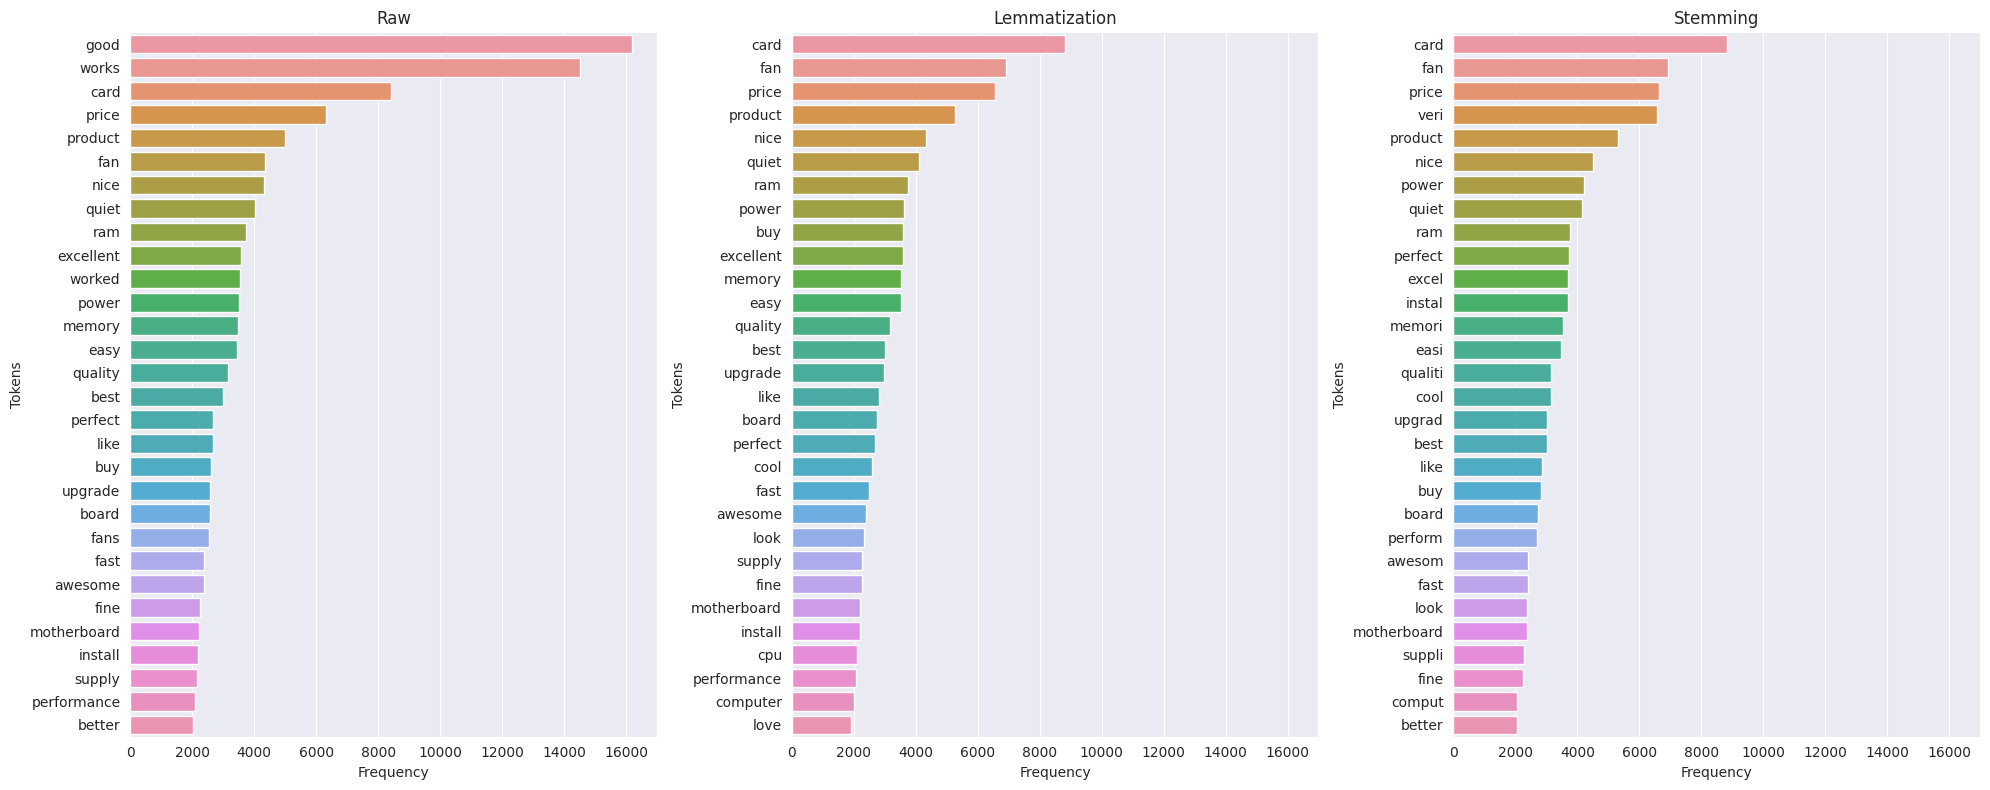

In [12]:
plot_tokens(summary_counters)

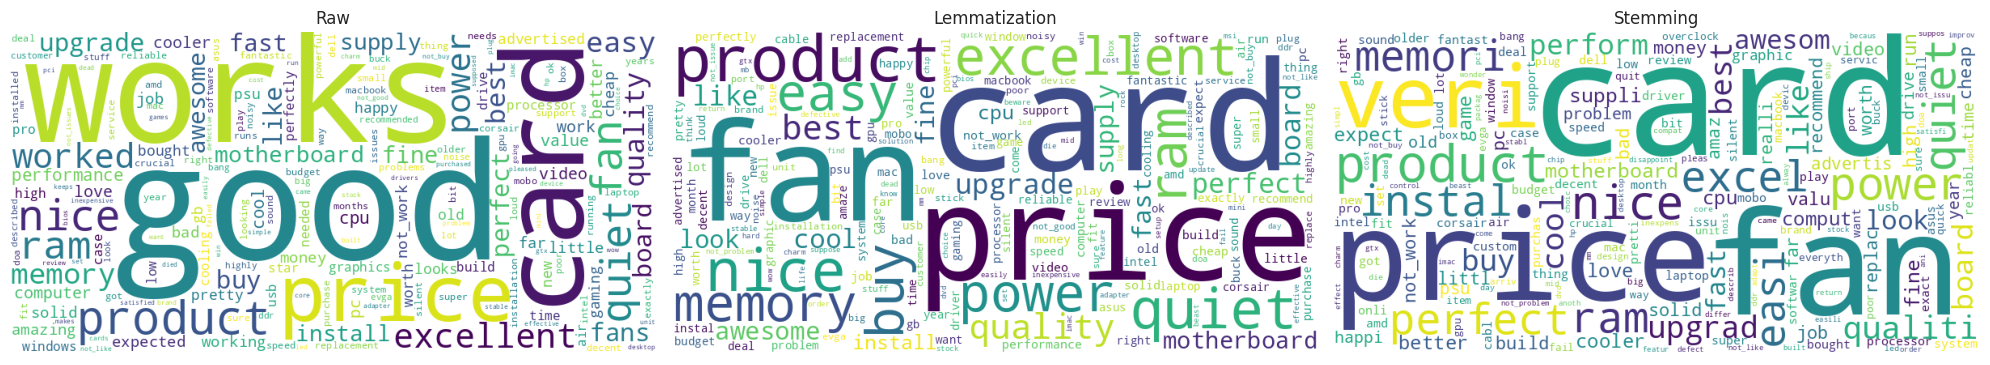

In [13]:
plot_tokens_wordcloud(summary_counters)

# Text Tokens

In [16]:
text_raw = preprocess_df(reviews_df, field="text")

Common: 0, Rare: 42324
Common: set()
Empty Docs: 0.23%


In [9]:
text_lemma = preprocess_df(
    reviews_df, field="text", normalize="lemmatization", out_dir=processed_data_dir
)

Common: 1, Rare: 37879
Common: {'work'}
Empty Docs: 1.26%


In [10]:
text_stem = preprocess_df(
    reviews_df, field="text", normalize="stemming", out_dir=processed_data_dir
)

Common: 2, Rare: 29444
Common: {'work', 'great'}
Empty Docs: 2.70%


In [11]:
text_counters = tokens_counters(
    text_raw["tokens"], text_lemma["tokens"], text_stem["tokens"]
)

for (title, counter) in text_counters.items():
    print(f"{title} Tokens:", len(counter.items()))

Raw Tokens: 25768
Lemmatization Tokens: 20496
Stemming Tokens: 16899


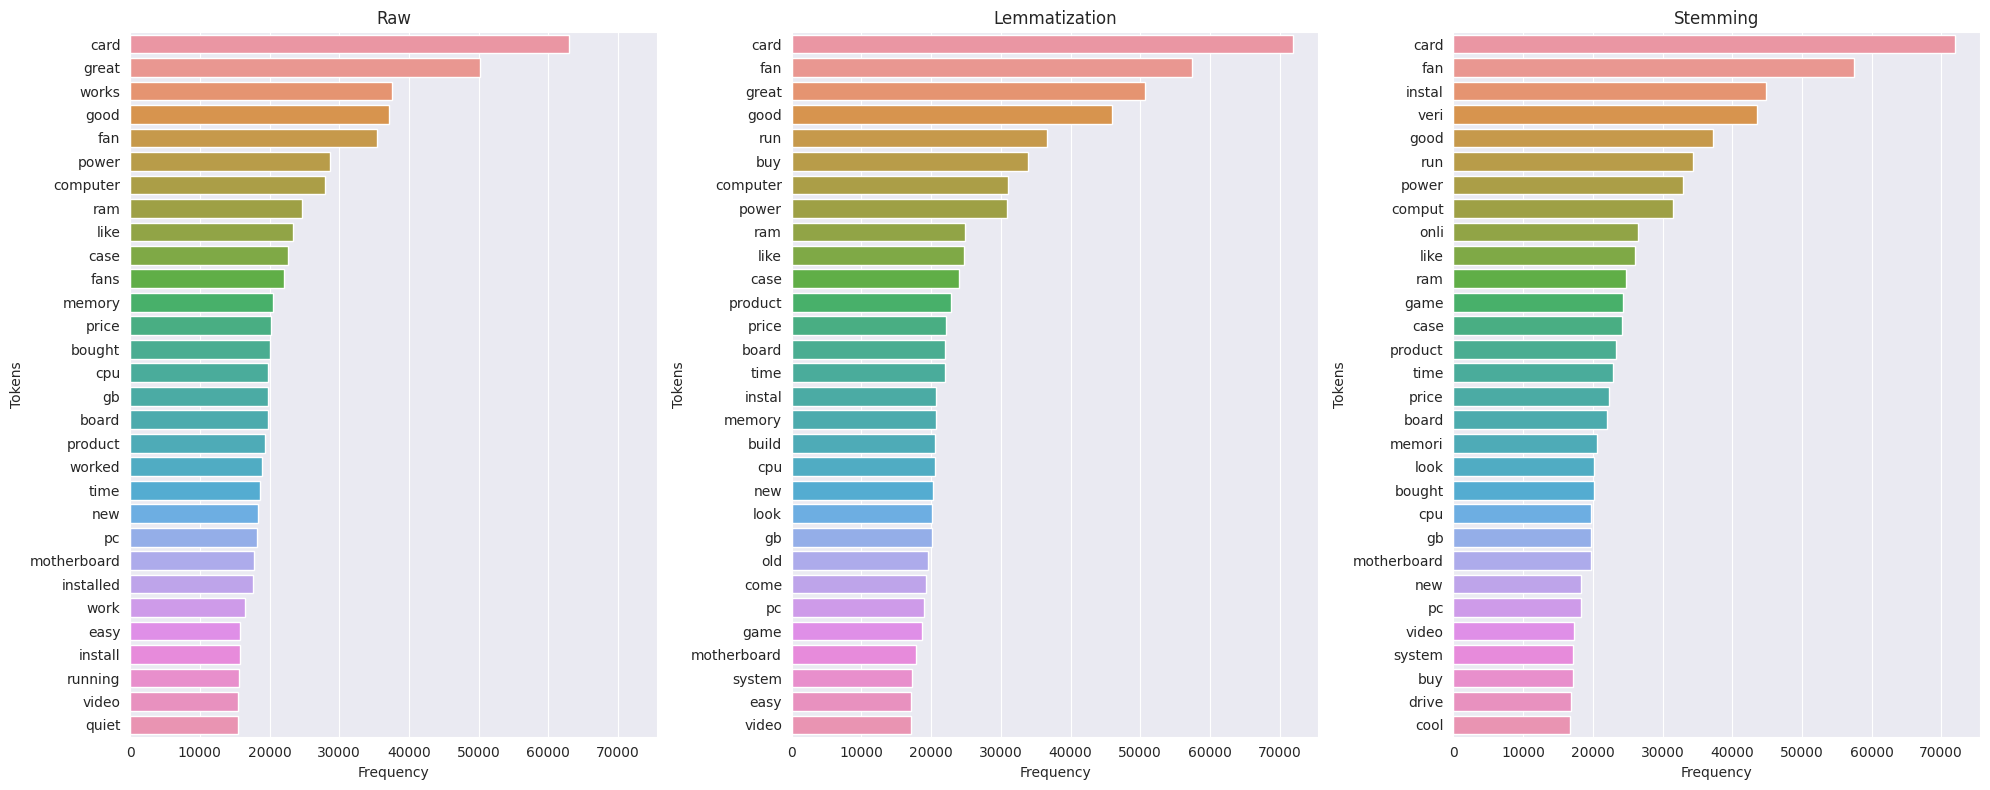

In [12]:
plot_tokens(text_counters)

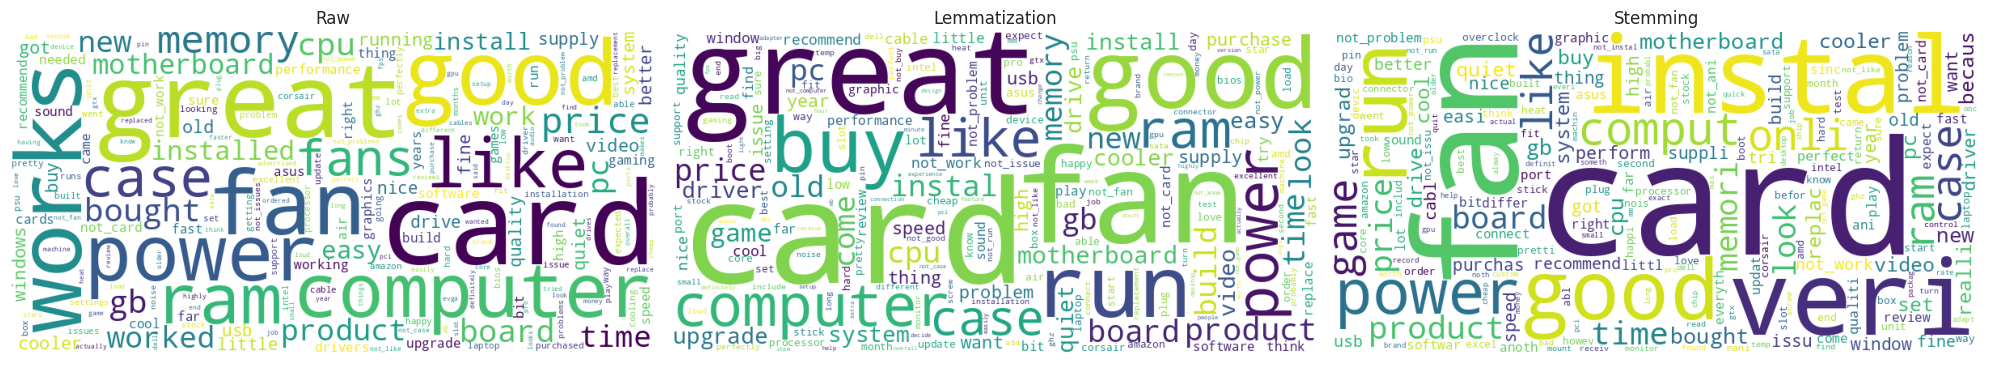

In [13]:
plot_tokens_wordcloud(text_counters)

# Polarity Analysis

In [14]:
# ground truth polarity
reviews_df["overall"] = reviews_df["overall"].parallel_apply(
    lambda x: "positive" if x > 3 else ("neutral" if x == 3 else "negative")
)

In [ ]:
positive_df = reviews_df[reviews_df["overall"] == "positive"]
positive_tokens = [
    word for doc in positive_df["tokens"] for sent in doc for word in sent
]
pos_c = Counter(positive_tokens)

print("positive tokens:", len(set(positive_tokens)))

negative_df = reviews_df[reviews_df["overall"] == "negative"]
negative_tokens = [
    word for doc in negative_df["tokens"] for sent in doc for word in sent
]
neg_c = Counter(negative_tokens)

print("negative tokens:", len(set(negative_tokens)))

In [ ]:
pos_data = pd.DataFrame(Counter(positive_tokens).most_common(30))
neg_data = pd.DataFrame(Counter(negative_tokens).most_common(30))

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(y=pos_data[0], x=pos_data[1], ax=ax[0])
sns.barplot(y=neg_data[0], x=neg_data[1], ax=ax[1])
fig.tight_layout()